# Lab | Generative Adversarial Network (GAN) on CIFAR-10 Dataset
### Generate Fun Colorful Images: Animals, Cars, and More!

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, datasets
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
import keras
from keras import layers, regularizers
###
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

## Load and preprocess CIFAR-10 dataset

In [2]:
# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to [-1, 1] (better for GAN training)
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Pixel value range: [{x_train.min():.2f}, {x_train.max():.2f}]")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Set parameters
# latent_dim = [32, 32, 3]   
latent_dim = 100

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Pixel value range: [-1.00, 1.00]


## Build the Generator Model

In [3]:
# Build the Generator Model
### YOUR CODE HERE

# Generator
def build_cnn_generator(latent_dim):
    model = keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),

        # First Conv2DTranspose: 8x8 → 16x16
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Second Conv2DTranspose: 16x16 → 32x32 (final size)
        # Changed from 64 to 3 channels and added tanh activation
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Example setup
latent_dim = 100  # Adjust based on your specific model configuration
cnn_generator = build_cnn_generator(latent_dim)
cnn_generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       5

2025-09-19 17:19:12.892521: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-09-19 17:19:12.892545: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-19 17:19:12.892551: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-19 17:19:12.892580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-19 17:19:12.892595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Build the Discriminator Model

In [4]:
# Build the Discriminator Model
### YOUR CODE HERE

def build_cnn_discriminator():
    model = keras.Sequential([
        # First convolution layer reduces the spatial dimension to 32x32
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),  # Dropout to reduce overfitting

        # Second convolution layer reduces the spatial dimension to 16x16
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),  # Additional dropout for robustness

        # Flatten the output to feed into a dense layer
        layers.Flatten(),

        # Output layer with a single neuron to classify real vs fake
        layers.Dense(1)  # Sigmoid activation to output probabilities
    ])
    return model

cnn_discriminator = build_cnn_discriminator()
cnn_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

## Define loss functions

In [5]:
# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # real_output: Discriminator's predictions on REAL images
    # fake_output: Discriminator's predictions on FAKE (generated) images

    ### YOUR CODE HERE
    # We need to calculate two separate losses and add them together.

    # 1. Loss on real images: Compare real_output to an array of 1s (the true label for real images)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # 2. Loss on fake images: Compare fake_output to an array of 0s (the true label for fake images)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Total loss is the sum of both parts
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    ### YOUR CODE HERE

    # fake_output: Discriminator's predictions on FAKE (generated) images

    # The generator wants the discriminator to think the fakes are real.
    # So, we compare fake_output to an array of 1s (what we WANT the discriminator to say).
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

## Define optimizers

In [6]:
# Define optimizers
### YOUR CODE HERE
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
###

## Training step function


In [7]:
# Training step function

@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape(persistent=True) as tape:
        # CHANGE: generator -> cnn_generator
        generated_images = cnn_generator(noise, training=True)
        
        # CHANGE: discriminator -> cnn_discriminator (for both lines)
        real_output = cnn_discriminator(real_images, training=True)
        fake_output = cnn_discriminator(generated_images, training=True)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)

    generator_gradients = tape.gradient(gen_loss, cnn_generator.trainable_variables)
    # CHANGE: discriminator -> cnn_discriminator
    discriminator_gradients = tape.gradient(disc_loss, cnn_discriminator.trainable_variables)
    
    # CHANGE: generator -> cnn_generator
    generator_optimizer.apply_gradients(zip(generator_gradients, cnn_generator.trainable_variables))
    # CHANGE: discriminator -> cnn_discriminator
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, cnn_discriminator.trainable_variables))
    
    return disc_loss, gen_loss

## Training parameters


In [8]:
# Training parameters
### YOUR CODE HERE

epochs = 10      # epoch =   50            # Number of times to loop through the entire dataset
batch_size = 128       # Number of images processed in one training step
num_batches = len(x_train) // batch_size # Calculate number of batches per epoch

# Create a fixed noise vector. We'll use this to generate images throughout training to see our progress.
# The images from this fixed seed will change as the generator learns.
seed = tf.random.normal([16, latent_dim]) # We'll generate 16 images to monitor

# How often to display generated images and print losses
print_interval = 5    # Do this every 5 epochs
###

In [9]:
# Test with a single sample
test_noise = tf.random.normal([1, latent_dim])
test_generated = cnn_generator(test_noise)
print(f"Generator output shape: {test_generated.shape}")

test_real = x_train[0:1]  # Get one real image
test_disc_real = cnn_discriminator(test_real)
print(f"Discriminator output for real image: {test_disc_real.shape}")

test_disc_fake = cnn_discriminator(test_generated)
print(f"Discriminator output for fake image: {test_disc_fake.shape}")

Generator output shape: (1, 32, 32, 3)
Discriminator output for real image: (1, 1)
Discriminator output for fake image: (1, 1)


## Train Model

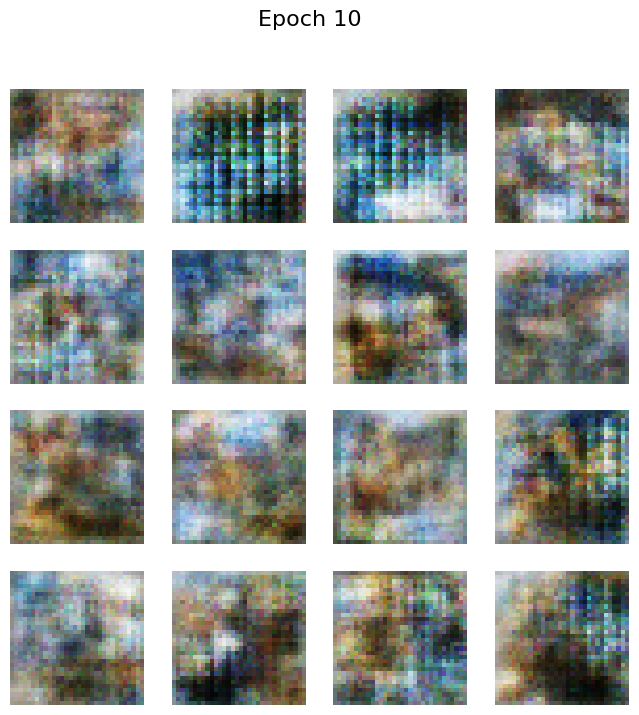

Epoch 10/10, Discriminator Loss: 1.3965, Generator Loss: 0.7422
Time for epoch: 49.54 seconds

Training finished!


In [10]:
# Lists to store the loss values for each epoch so we can plot them later
discriminator_losses = []
generator_losses = []

from tqdm.notebook import tqdm


# 1. The Training Loop: Loop for each epoch
for epoch in range(epochs):
    start = time.time() # Start a timer for this epoch

    # 2. Loop through all batches in the training data
    for batch_index in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}"):

        # 3. Get a batch of real images for this training step
        # Calculate the start and end index for the current batch
        start_idx = batch_index * batch_size
        end_idx = start_idx + batch_size
        real_batch = x_train[start_idx:end_idx]

        # 4. THE CORE ACTION: Perform one training step on this batch
        # This function does everything: generates fakes, calculates loss, calculates gradients, updates weights.
        d_loss, g_loss = train_step(real_batch)

    # 5. Save the losses for this epoch to our lists
    # We use .numpy() to convert the TensorFlow tensor to a regular Python number for storing
    discriminator_losses.append(d_loss.numpy())
    generator_losses.append(g_loss.numpy())

    # 6. Monitor Progress: Generate images using the fixed seed at specified intervals
    if (epoch + 1) % print_interval == 0:
        # Clear the previous output in the notebook cell
        clear_output(wait=True)

        # Use the generator in inference mode (training=False) to create images from the fixed seed
        generated_images = cnn_generator(seed, training=False)

        # Plot the generated images in a grid
        fig, axs = plt.subplots(4, 4, figsize=(8, 8)) # Create a 4x4 grid of subplots
        fig.suptitle(f'Epoch {epoch+1}', fontsize=16)
        count = 0
        for i in range(4):
            for j in range(4):
                # Display the image. Generated images are normalized to [-1, 1], so we shift them back to [0, 1] for plotting
                axs[i, j].imshow((generated_images[count] + 1) / 2.0)
                axs[i, j].axis('off') # Remove axes
                count += 1
        plt.show()

        # Print the losses and time for this epoch
        print(f'Epoch {epoch+1}/{epochs}, Discriminator Loss: {d_loss:.4f}, Generator Loss: {g_loss:.4f}')
        print(f'Time for epoch: {time.time() - start:.2f} seconds\n')

# 7. Training complete!
print("Training finished!")

## Exercise 1: Plot Training Losses

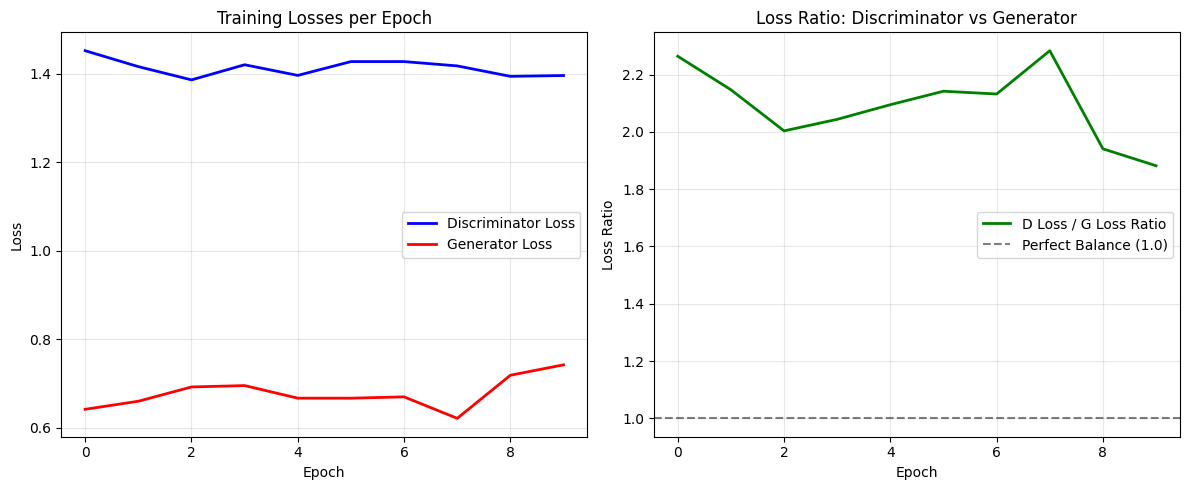

Loss Analysis:
Final Discriminator Loss: 1.3965
Final Generator Loss: 0.7422
Final Loss Ratio: 1.88
→ Good balance! Both models are learning and competing.


In [11]:
### YOUR CODE HERE - Exercise 1 ###


# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Plot 1: Individual Losses
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(discriminator_losses, label='Discriminator Loss', color='blue', linewidth=2)
plt.plot(generator_losses, label='Generator Loss', color='red', linewidth=2)
plt.title('Training Losses per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Loss Ratio (helps see if one model is dominating)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
# Calculate the ratio: Discriminator Loss / Generator Loss
loss_ratio = [d_loss / g_loss for d_loss, g_loss in zip(discriminator_losses, generator_losses)]
plt.plot(loss_ratio, label='D Loss / G Loss Ratio', color='green', linewidth=2)
plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Perfect Balance (1.0)')
plt.title('Loss Ratio: Discriminator vs Generator')
plt.xlabel('Epoch')
plt.ylabel('Loss Ratio')
plt.legend()
plt.grid(True, alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print some analysis
print("Loss Analysis:")
print(f"Final Discriminator Loss: {discriminator_losses[-1]:.4f}")
print(f"Final Generator Loss: {generator_losses[-1]:.4f}")
print(f"Final Loss Ratio: {loss_ratio[-1]:.2f}")

# Interpret the results
if loss_ratio[-1] > 2.0:
    print("→ The Discriminator is too strong! It's easily spotting fakes.")
elif loss_ratio[-1] < 0.5:
    print("→ The Generator is too strong! It's fooling the Discriminator easily.")
else:
    print("→ Good balance! Both models are learning and competing.")


## Exercise 2: Generate Image Grid

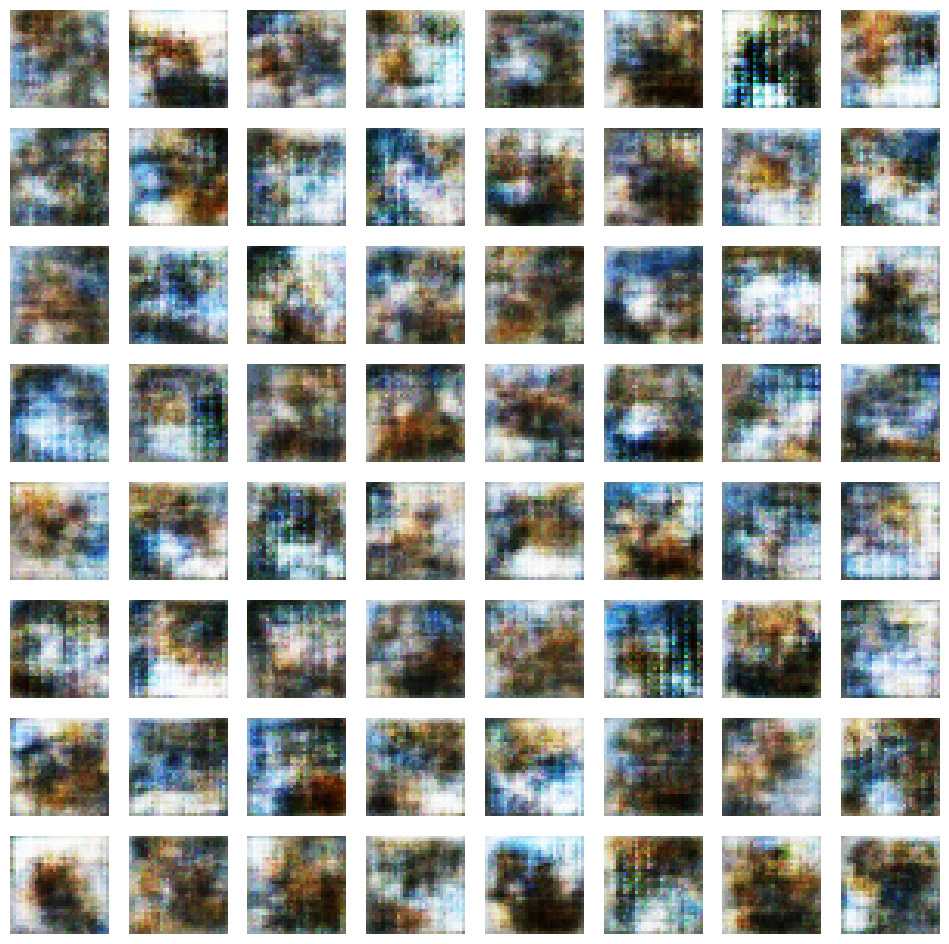

In [13]:
grid_size = 8  # 8x8 grid → 64 images
num_images = grid_size * grid_size

# Generate random latent vectors
noise = tf.random.normal([num_images, latent_dim])

# Generate images from the generator
generated_images = cnn_generator(noise, training=False)

# Plot images in a grid
fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))
count = 0
for i in range(grid_size):
    for j in range(grid_size):
        # Convert from [-1,1] to [0,1]
        img = (generated_images[count] + 1) / 2.0
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        count += 1
plt.show()


## Exercise 3: Compare Real vs Generated Images

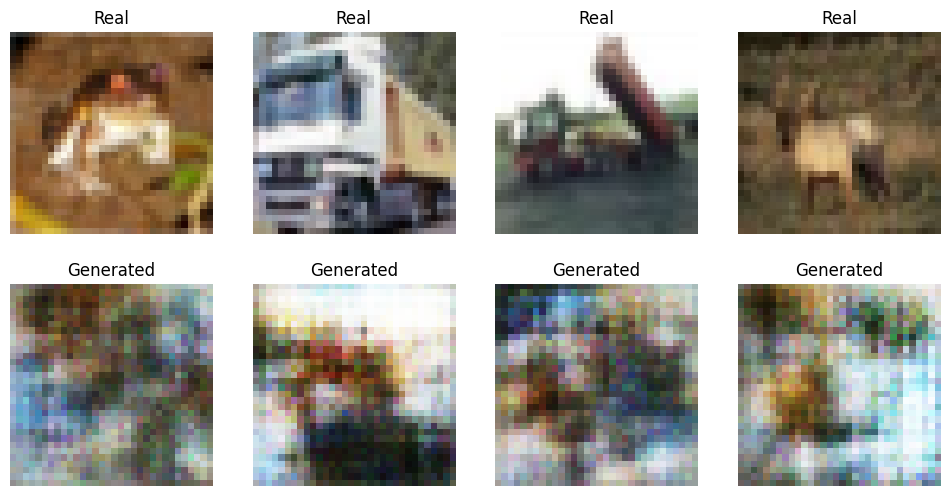

In [14]:
### YOUR CODE HERE - Exercise 3 ###

n_images = 4  # Number of images to compare

# Select n real images
real_images = x_train[:n_images]

# Generate n fake images
noise = tf.random.normal([n_images, latent_dim])
fake_images = cnn_generator(noise, training=False)

# Plot
fig, axs = plt.subplots(2, n_images, figsize=(n_images*3, 6))
for i in range(n_images):
    # Real images on first row
    axs[0, i].imshow((real_images[i] + 1) / 2.0)
    axs[0, i].set_title("Real")
    axs[0, i].axis('off')
    
    # Generated images on second row
    axs[1, i].imshow((fake_images[i] + 1) / 2.0)
    axs[1, i].set_title("Generated")
    axs[1, i].axis('off')

plt.show()


## Exercise 4: Latent Space Interpolation

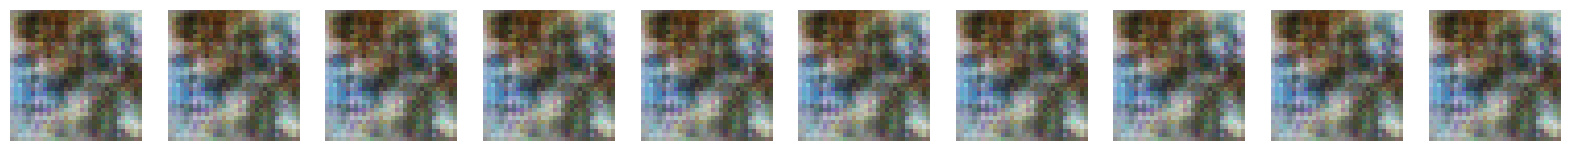

In [15]:
### YOUR CODE HERE - Exercise 4 ###

# Two random latent vectors
z1 = tf.random.normal([1, latent_dim])
z2 = tf.random.normal([1, latent_dim])

# Number of interpolation steps
steps = 10

interpolated_images = []
for alpha in tf.linspace(0.0, 1.0, steps):
    z = z1 * (1 - alpha) + z2 * alpha  # Linear interpolation
    img = cnn_generator(z, training=False)
    interpolated_images.append(img[0])

# Plot
fig, axs = plt.subplots(1, steps, figsize=(steps*2, 2))
for i, img in enumerate(interpolated_images):
    axs[i].imshow((img + 1)/2.0)
    axs[i].axis('off')
plt.show()


## Bonus Exercise: Model Summaries

In [16]:
### YOUR CODE HERE - Bonus ###
# Display the architecture of your models
# Use generator.summary() and discriminator.summary()
# Analyze the number of parameters in each model

# Generator summary
print("Generator Model:")
cnn_generator.summary()

# Discriminator summary
print("\nDiscriminator Model:")
cnn_discriminator.summary()


Generator Model:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16,

------
# DRAFTs

In [ ]:
# Train Convolutional GAN
# cnn_gan.fit(dataset, epochs=2)

In [ ]:
# # Define optimizers
# ### YOUR CODE HERE

# cnn_gan = GAN(discriminator=cnn_discriminator, generator=cnn_generator, latent_dim=latent_dim)
# cnn_gan.compile(
#     d_optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5),
#     g_optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5),
#     loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# )

In [ ]:
# # Training step function

# # This decorator tells TensorFlow to compile the function for faster execution.
# @tf.function
# def train_step(real_images):
#     """
#     Performs one training step on a batch of real images.
#     1. Generates fake images from random noise.
#     2. Feeds both real and fake images to the discriminator.
#     3. Calculates the loss for both models.
#     4. Calculates the gradients and updates both models' weights.
#     """
#     # 1. Generate a batch of random noise vectors
#     batch_size = tf.shape(real_images)[0] # Get the number of images in this batch
#     noise = tf.random.normal([batch_size, latent_dim])

#     # 2. Record the operations for automatic differentiation
#     with tf.GradientTape(persistent=True) as tape:
#         # 3. Generate fake images from the noise
#         generated_images = generator(noise, training=True)

#         # 4. Get the discriminator's predictions on both sets of images
#         real_output = discriminator(real_images, training=True)
#         fake_output = discriminator(generated_images, training=True)

#         # 5. Calculate the loss for each model using our functions
#         disc_loss = discriminator_loss(real_output, fake_output)
#         gen_loss = generator_loss(fake_output)

#     # 6. Calculate the gradients (the "how to change" instructions)
#     # Calculate gradients for the generator
#     generator_gradients = tape.gradient(gen_loss, generator.trainable_variables)
#     # Calculate gradients for the discriminator
#     discriminator_gradients = tape.gradient(disc_loss, discriminator.trainable_variables)

#     # 7. Apply the gradients to update the models
#     generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

#     # 8. (Optional) Return the losses so we can track them
#     return disc_loss, gen_loss

In [ ]:
# # Training step function

# # This decorator tells TensorFlow to compile the function for faster execution.
# @tf.function
# def train_step(real_images):
#     """
#     Performs one training step on a batch of real images.
#     1. Generates fake images from random noise.
#     2. Feeds both real and fake images to the discriminator.
#     3. Calculates the loss for both models.
#     4. Calculates the gradients and updates both models' weights.
#     """
#     # 1. Generate a batch of random noise vectors
#     batch_size = tf.shape(real_images)[0] # Get the number of images in this batch
#     noise = tf.random.normal([batch_size, latent_dim])

#     # 2. Record the operations for automatic differentiation
#     with tf.GradientTape(persistent=True) as tape:
#         # 3. Generate fake images from the noise
#         generated_images = generator(noise, training=True)

#         # 4. Get the discriminator's predictions on both sets of images
#         real_output = discriminator(real_images, training=True)
#         fake_output = discriminator(generated_images, training=True)

#         # 5. Calculate the loss for each model using our functions
#         disc_loss = discriminator_loss(real_output, fake_output)
#         gen_loss = generator_loss(fake_output)

#     # 6. Calculate the gradients (the "how to change" instructions)
#     # Calculate gradients for the generator
#     generator_gradients = tape.gradient(gen_loss, generator.trainable_variables)
#     # Calculate gradients for the discriminator
#     discriminator_gradients = tape.gradient(disc_loss, discriminator.trainable_variables)

#     # 7. Apply the gradients to update the models
#     generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

#     # 8. (Optional) Return the losses so we can track them
#     return disc_loss, gen_loss